In [10]:
from sogym.env import sogym
from sogym.utils import FigureRecorderCallback
import numpy as np
import stable_baselines3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv
from stable_baselines3 import PPO
%load_ext autoreload
%autoreload 2
print('SB3 vestsion:', stable_baselines3.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
SB3 vestsion: 1.7.0


---
### Environment test and visualization:

In [11]:
from stable_baselines3.common.env_checker import check_env
# It will check your custom environment and output additional warnings if needed
check_env(sogym(nelx=100,nely=50,mode='train',observation_type='image'))

720 360
(777600,)
720 360
(777600,)


In [12]:
# Let's test the environment using the check_env util from SB3:
train_env = sogym(nelx=100,nely=50,mode='train',observation_type='dense')
eval_env = sogym(nelx=100,nely=50,mode='test',observation_type='dense')

In [13]:
# The training environment and the eval environment both have a different boundary conditions distribution:
print("Number of unique BC + desired volume frac combinations in the train distribution: ",len(train_env.BC_dict))
print("Number of unique BC + desired volume frac combinations in the test distribution: ",len(eval_env.BC_dict))

Number of unique BC + desired volume frac combinations in the train distribution:  4284
Number of unique BC + desired volume frac combinations in the test distribution:  2412


Volume:  0.48125770868193973
Reward  0.002844766238289021


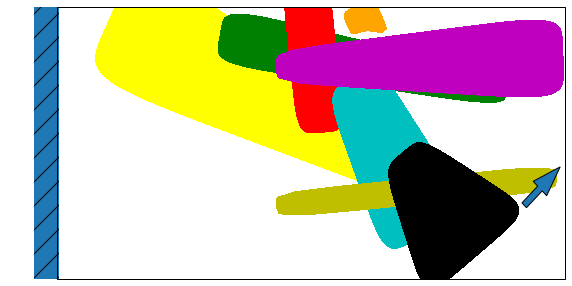

In [14]:
# Let's visualize the training environment on a random problem statement and visualize a 'successful' solution:
reward = 0.0
while reward<1e-3:
    obs = train_env.reset()
    done = False
    while not done:
        action = train_env.action_space.sample()
        obs, reward, done, info = train_env.step(action)
print("Volume: ", train_env.volume)
print("Reward ",reward)

train_env.plot()

In [15]:
train_env.gen_image()

720 360
(777600,)


array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)

Volume:  0.6646823090524662
Reward  0.0


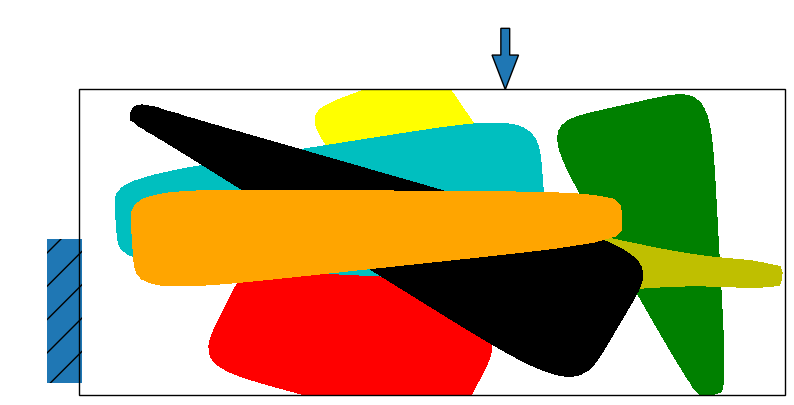

In [6]:
# Let's visualize the eval environment:
obs = eval_env.reset()
done = False
while not done:
    action = eval_env.action_space.sample()
    obs, reward, done, info = eval_env.step(action)
print("Volume: ", eval_env.volume)
print("Reward ",reward)
eval_env.plot()

---
### Multiprocessing

In [25]:
num_cpu = 32 # Number of processes to use
train_env = sogym(mode='train',observation_type='image')
env= make_vec_env(lambda:train_env, n_envs=num_cpu,vec_env_cls=SubprocVecEnv)
env=VecNormalize(env,gamma=1.0)

eval_env = sogym(mode='test',observation_type='image')
eval_env = make_vec_env(lambda:eval_env, n_envs=1,vec_env_cls=SubprocVecEnv)
eval_env =VecNormalize(eval_env,gamma=1.0)


In [26]:
# Let's  test that an eval callback actually works:
from stable_baselines3.common.callbacks import EvalCallback, CallbackList

eval_callback = EvalCallback(eval_env,log_path='tb_logs',eval_freq=100,deterministic=True,render=False)
callback = CallbackList([eval_callback,
                         FigureRecorderCallback(check_freq=8*32)])

--- 
### Defining the model

In [28]:
import gym
import torch as th
from torch import nn

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class CustomCombinedExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Dict):
        # We do not know features-dim here before going over all the items,
        # so put something dummy for now. PyTorch requires calling
        # nn.Module.__init__ before adding modules

        super(CustomCombinedExtractor, self).__init__(observation_space, features_dim=1)
        self.drop_rate = 0.4
        self.activ_func = nn.ReLU()
        extractors = {}

        total_concat_size = 0
        # We need to know size of the output of this extractor,
        # so go over all the spaces and compute output feature sizes
        for key, subspace in observation_space.spaces.items():
            
            if key =='image':
                n_input_channels = subspace.shape[0]
                extractors[key]= nn.Sequential(
                                                nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=2, padding=1), #Out is 32 x 62 x 30
                                                nn.ReLU(),
                                                nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), #Out is 64 x 31 x 15
                                                nn.ReLU(),
                                                nn.Flatten(),
                                            )
                total_concat_size+= 29760

            
            elif key == "design_variables" or key=="volume" or key=="n_steps_left":
                extractors[key] = nn.Sequential(
                                                #nn.Linear(subspace.shape[0], 128),
                                                #self.activ_func,
                                                #nn.Dropout(p=self.drop_rate),
                                                #nn.Linear(128,128),
                                                #self.activ_func,
                                                #nn.Dropout(p=self.drop_rate),
                                                nn.Flatten()
                                               )
                #total_concat_size += (128)
                total_concat_size+=(subspace.shape[0])

            
            elif key == "conditions" :
                # Run through a simple MLP
                extractors[key] = nn.Sequential(
                                                nn.Linear(subspace.shape[0], 128),
                                                self.activ_func,
                                                nn.Dropout(p=self.drop_rate),
                                                nn.Linear(128,128),
                                                self.activ_func,
                                                nn.Dropout(p=self.drop_rate),
                                                nn.Flatten()
                                               )
                total_concat_size += (128)
                #total_concat_size+=(subspace.shape[0])
                
           
           
          
         
        self.extractors = nn.ModuleDict(extractors)

        # Update the features dim manually
        self._features_dim = total_concat_size

    def forward(self, observations) -> th.Tensor:
        encoded_tensor_list = []

        # self.extractors contain nn.Modules that do all the processing.
        for key, extractor in self.extractors.items():
            encoded_tensor_list.append(extractor(observations[key]))
        # Return a (B, self._features_dim) PyTorch tensor, where B is batch dimension.
        return th.cat(encoded_tensor_list, dim=1)
    
policy_kwargs = dict(
    features_extractor_class=CustomCombinedExtractor,
    #net_arch=[dict(pi=[1024,1024,1024], vf=[1024,1024,1024])],
               optimizer_kwargs={"weight_decay": 1e-4},
    
)

In [29]:
model = PPO("MultiInputPolicy",
            env,
            seed=42,
            policy_kwargs = policy_kwargs,
            n_steps=32,
            batch_size=1024,
            verbose=0,
            gamma=1.0,
            ent_coef=3e-4,
            tensorboard_log="tb_logs",
            device='cuda')


--- 
### Training

In [31]:
#model.learn(5000000,callback=callback,tb_log_name='PPO_test_5M')
model.save('model_saved',)
env.save('env_saved.pkl')

In [24]:
num_cpu = 32 # Number of processes to use
train_env = sogym(mode='train',observation_type='image')
env= make_vec_env(lambda:train_env, n_envs=num_cpu,vec_env_cls=SubprocVecEnv)
env = VecNormalize.load('env_saved.pkl',env)

eval_env = sogym(mode='test',observation_type='image')
eval_env = make_vec_env(lambda:eval_env, n_envs=1,vec_env_cls=SubprocVecEnv)
eval_env = VecNormalize.load('env_saved.pkl',eval_env)

model.load('model_saved',env=env,device='cuda')
model.learn(500000,callback=callback,reset_num_timesteps=False,tb_log_name='PPO_test_1M')
model.save('model_saved_1M',)
env.save('env_saved_1M.pkl')

ValueError: Observation spaces do not match: Dict(conditions:Box([-1. -1. -1. -1. -1. -1. -1. -1. -1.], [1. 1. 1. 1. 1. 1. 1. 1. 1.], (9,), float32), design_variables:Box([-3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927
 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927
 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927
 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927
 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927
 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927
 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927
 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927], [3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927
 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927
 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927
 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927
 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927
 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927
 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927], (48,), float32), image:Box([[[-10. -10. -10. ... -10. -10. -10.]
  [-10. -10. -10. ... -10. -10. -10.]
  [-10. -10. -10. ... -10. -10. -10.]
  ...
  [-10. -10. -10. ... -10. -10. -10.]
  [-10. -10. -10. ... -10. -10. -10.]
  [-10. -10. -10. ... -10. -10. -10.]]

 [[-10. -10. -10. ... -10. -10. -10.]
  [-10. -10. -10. ... -10. -10. -10.]
  [-10. -10. -10. ... -10. -10. -10.]
  ...
  [-10. -10. -10. ... -10. -10. -10.]
  [-10. -10. -10. ... -10. -10. -10.]
  [-10. -10. -10. ... -10. -10. -10.]]

 [[-10. -10. -10. ... -10. -10. -10.]
  [-10. -10. -10. ... -10. -10. -10.]
  [-10. -10. -10. ... -10. -10. -10.]
  ...
  [-10. -10. -10. ... -10. -10. -10.]
  [-10. -10. -10. ... -10. -10. -10.]
  [-10. -10. -10. ... -10. -10. -10.]]], [[[10. 10. 10. ... 10. 10. 10.]
  [10. 10. 10. ... 10. 10. 10.]
  [10. 10. 10. ... 10. 10. 10.]
  ...
  [10. 10. 10. ... 10. 10. 10.]
  [10. 10. 10. ... 10. 10. 10.]
  [10. 10. 10. ... 10. 10. 10.]]

 [[10. 10. 10. ... 10. 10. 10.]
  [10. 10. 10. ... 10. 10. 10.]
  [10. 10. 10. ... 10. 10. 10.]
  ...
  [10. 10. 10. ... 10. 10. 10.]
  [10. 10. 10. ... 10. 10. 10.]
  [10. 10. 10. ... 10. 10. 10.]]

 [[10. 10. 10. ... 10. 10. 10.]
  [10. 10. 10. ... 10. 10. 10.]
  [10. 10. 10. ... 10. 10. 10.]
  ...
  [10. 10. 10. ... 10. 10. 10.]
  [10. 10. 10. ... 10. 10. 10.]
  [10. 10. 10. ... 10. 10. 10.]]], (3, 64, 128), float32), n_steps_left:Box([0.], [1.], (1,), float32), volume:Box([0.], [1.], (1,), float32)) != Dict(conditions:Box([-1. -1. -1. -1. -1. -1. -1. -1. -1.], [1. 1. 1. 1. 1. 1. 1. 1. 1.], (9,), float32), design_variables:Box([-3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927
 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927
 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927
 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927
 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927
 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927
 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927
 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927 -3.1415927], [3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927
 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927
 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927
 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927
 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927
 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927
 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927 3.1415927], (48,), float32), image:Box([[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]], [[[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]

 [[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]

 [[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]], (3, 64, 128), uint8), n_steps_left:Box([0.], [1.], (1,), float32), volume:Box([0.], [1.], (1,), float32))

---
### Let's visualize the agent's performance:

In [32]:
env=sogym(mode='test',observation_type='image')
env = make_vec_env(lambda:env, n_envs=1,vec_env_cls=SubprocVecEnv)
env = VecNormalize.load('env_saved.pkl',env)
env.training=False
env.norm_reward=False
model=model.load('model_saved')
#model.set_env(env)

[[0.90895426 1.         1.         0.23904514 1.         1.        ]]
[[ 1.          1.          1.         -0.64072937 -0.13095489  1.        ]]
[[ 1.          1.          1.         -0.33366826 -1.         -1.        ]]
[[ 0.6160467   0.0888018   0.13543001  0.13374622 -1.         -1.        ]]
[[-0.43506697 -1.         -1.          1.         -1.         -1.        ]]
[[-1. -1. -1.  1. -1. -1.]]
[[-0.50761825 -1.         -1.          1.         -1.         -1.        ]]
[[-1. -1. -1.  1. -1. -1.]]
Reward: 0.0021147175758949974


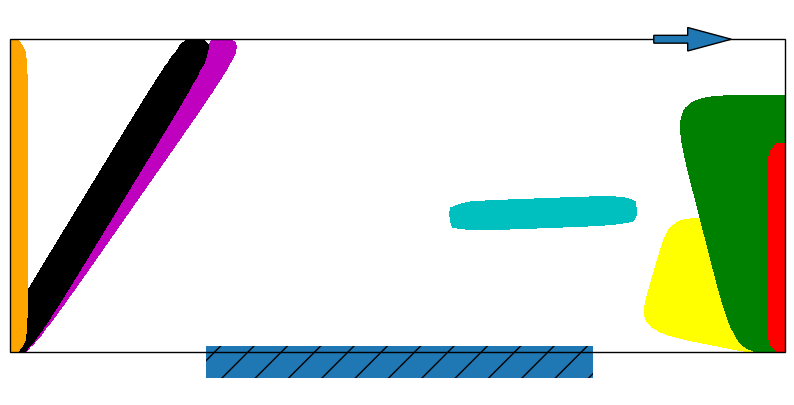

In [35]:
obs=env.reset()
dones=False

while dones== False:
    action, _states = model.predict(obs,deterministic=True)
    print(action)
    obs, rewards, dones, info = env.step(action)
  
print("Reward:",rewards[0])
#print("Volume:",np.round(env.get_attr('volume')[0]*100,2),"%")
fig=env.env_method('plot')[0]
#fig = env.render()

fig

In [36]:
env.get_attr('H')[0].shape

(5151,)

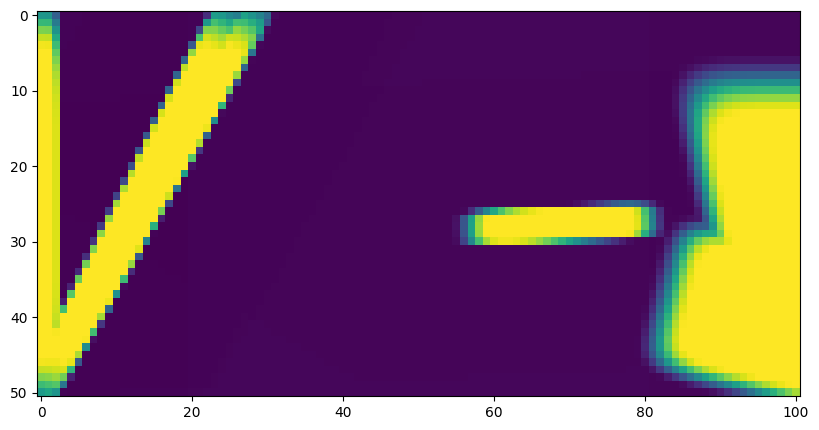

In [39]:
import matplotlib.pyplot as plt
plt.imshow(env.get_attr('H')[0].reshape((51,101),order='F'))